In [1]:
import sklearn_crfsuite
from type import CrfFeatures, Abbreviation, CrfLabel
import json
from sklearn.model_selection import train_test_split
import sklearn_crfsuite.metrics
from util.levenshtein_distance import edit_dist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 前処理した略語データを読み込む
data = list(map(Abbreviation.model_validate, json.load(open("./data/abbreviation.json", "r"))))
data_train: list[Abbreviation] = []
data_test: list[Abbreviation] = []
data_train, data_test = train_test_split(data, test_size=0.2)

In [3]:
X_train = [list(map(lambda f: f.get_array(), feature_list)) for feature_list in map(CrfFeatures.from_abbreviation, data_train)]
y_train = list(map(CrfLabel.from_abbreviation, data_train))
X_test = [list(map(lambda f: f.get_array(), feature_list)) for feature_list in map(CrfFeatures.from_abbreviation, data_test)]
y_test = list(map(CrfLabel.from_abbreviation, data_test))

In [4]:
model = sklearn_crfsuite.CRF(algorithm="lbfgs", c1=0.1, c2=0.1, max_iterations=100000, all_possible_transitions=True)
model.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100000)

In [5]:
y_pred = model.predict(X_test)

In [6]:
sklearn_crfsuite.metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.7412871014905937

In [17]:
test_n = len(y_test)
correct_n = 0
score_list = np.array([0.0] * test_n) # スコアは 編集距離 / 単語のモーラ数 で定義する

for i in range(len(y_test)):
    word_mora_list = [mora for elem in data_test[i].word_element_list for mora in elem.mora_list]
    word = " ".join([f"{mora.consonant}{mora.vowel}" for mora in word_mora_list])
    abbr_pred_list: list[str] = []
    assert len(y_pred[i]) == len(y_test[i]) == len(word_mora_list)
    for j in range(len(y_test[i])):
        if y_pred[i][j] == CrfLabel.OK:
            abbr_pred_list.append(word_mora_list[j].consonant + word_mora_list[j].vowel)
    score_list[i] = edit_dist(y_pred[i], y_test[i]) / len(y_test[i])
    correct_n += y_pred[i] == y_test[i]
    print('{:.3f}'.format(score_list[i]), f"{word} -> {' '.join(abbr_pred_list)}")

0.000 wa i do re N zu -> wa i do
0.000 ra bo ra to ri i -> ra bo
0.286 fu ri i ra N sa a -> fu ri i ra N
0.000 byu u thi i -> byu u
0.000 ta gu bo o to -> ta gu
0.000 sa bu su thi i te yu u to -> sa bu
0.000 he te ro se ku shu a ru -> he te ro
0.200 de ko me e ru -> de ko
0.000 su ta ji o -> su ta
0.444 ka N ni N gu pe e pa a -> ka N ni N gu pe e
0.286 ra i fu ja ke Q to -> ra i
0.000 fe su thi ba ru -> fe su
0.333 ha i ya a ka a -> ha i ya a ka a
0.125 ro N gu ba ke e sho N -> ro N gu ba ke
0.200 de gu re e to -> de gu
0.500 ga a ri Q ku ba ta a -> ga a
0.250 na N ba a pu re e to -> na N ba a pu re
0.222 a me ri ka N ko o hi i -> a me ri ka N ko o
0.000 su ko Q chi tsu i i do -> su ko Q chi
0.625 ko myu ni thi ka re Q ji -> ko myu ni thi ka re
1.000 te e bu ru na i fu -> te e bu ru
0.143 pa a su pe ku chi bu -> pa a
0.200 ma ji Q ku ko N pyu u ta a -> ma ji Q ku ko N
0.333 da N su do ri ru -> da N
0.556 dhi fe N su ko N dhi sho N -> dhi fe N su ko N
0.273 e ku su pu re Q su to re e N 

In [9]:
print(f"Accuracy: {correct_n / test_n}")

Accuracy: 0.3188976377952756


(array([81., 28., 71., 23., 10., 17.,  6.,  9.,  1.,  8.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

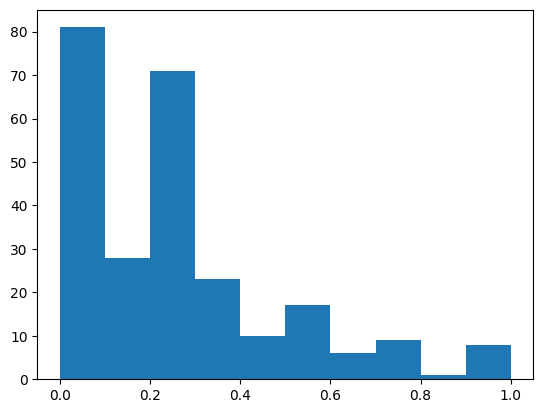

In [10]:
plt.hist(score_list, bins=10)